<a href="https://colab.research.google.com/github/iamhero2709/30-Days-Of-React/blob/master/tensorflow_withdl/Autoencoders_tensorflow8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# downloading utils.py
import urllib.request
with urllib.request.urlopen("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week4/data/utils.py") as url:
    response = url.read()
target = open('utils.py', 'w')
target.write(response.decode('utf-8'))
target.close()

In [2]:
import tensorflow as tf
import numpy as np

from PIL import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# data Loading an dpreprocessing
# importing MNIST data
# Import MINST data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# normalizing pixel value
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [7]:
# normalizing labels
#Not Directly Used for Autoencoder Input
y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

In [9]:
#Reshaping for Potential CNN Use (and TensorFlow Compatibility)
x_image_train = tf.reshape(x_train, [-1,28,28,1])
x_image_train = tf.cast(x_image_train, 'float32')

x_image_test = tf.reshape(x_test, [-1,28,28,1])
x_image_test = tf.cast(x_image_test, 'float32')

In [10]:
# densostarting flattening
print(x_train.shape)
# Output: (60000, 28, 28)

flatten_layer = tf.keras.layers.Flatten()
x_train = flatten_layer(x_train)

print(x_train.shape)
# Output: (60000, 784)

(60000, 28, 28)
(60000, 784)


In [11]:
#3. Autoencoder Architecture Parameters
# defining netwrok parameteres
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10
global_step = tf.Variable(0) # Not used in the training loop directly, but a common placeholder
total_batch = int(len(x_train) / batch_size)

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
encoding_layer = 32 # final encoding bottleneck features
n_input = 784 # MNIST data input (img shape: 28*28)

In [12]:
#buidling encoder and decoder with keras layer
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Store network parameters as attributes (optional but good practice)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.encoding_layer = encoding_layer
        self.n_input = n_input

        # Define all the layers as attributes of the class
        # Encoder Layers
        self.flatten_layer = tf.keras.layers.Flatten() # Used in the original functional definition,
                                                        # but inputs are already flattened in training loop
        self.enocoding_1 = tf.keras.layers.Dense(self.n_hidden_1, activation=tf.nn.sigmoid)
        self.encoding_2 = tf.keras.layers.Dense(self.n_hidden_2, activation=tf.nn.sigmoid)
        self.encoding_final = tf.keras.layers.Dense(self.encoding_layer, activation=tf.nn.relu)

        # Decoder Layers (mirroring the encoder in reverse)
        self.decoding_1 = tf.keras.layers.Dense(self.n_hidden_2, activation=tf.nn.sigmoid)
        self.decoding_2 = tf.keras.layers.Dense(self.n_hidden_1, activation=tf.nn.sigmoid)
        self.decoding_final = tf.keras.layers.Dense(self.n_input) # Output layer: no activation (linear) for MSE loss

    # Method to define the encoder's forward pass
    def encoder(self,x):
        # x = self.flatten_layer(x) # This line is commented out; inputs are expected to be flattened already
        layer_1 = self.enocoding_1(x)
        layer_2 = self.encoding_2(layer_1)
        code = self.encoding_final(layer_2) # This is the compressed representation
        return code

    # Method to define the decoder's forward pass
    def decoder(self, x): # 'x' here is the compressed code from the encoder
        layer_1 = self.decoding_1(x)
        layer_2 = self.decoding_2(layer_1)
        decode = self.decoding_final(layer_2) # This is the reconstructed output
        return decode

    # The main forward pass method for the entire AutoEncoder model
    def call(self, x):
        encoder_op  = self.encoder(x) # First, encode the input
        y_pred = self.decoder(encoder_op) # Then, decode the encoded representation
        return y_pred

In [15]:
# defining cost and gradient function
def cost(y_true, y_pred):
    # Use tf.keras.losses.MeanSquaredError
    loss_fn = tf.keras.losses.MeanSquaredError()
    loss = loss_fn(y_true, y_pred)
    cost = tf.reduce_mean(loss) # Average loss over the batch
    return cost

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        reconstruction = model(inputs) # Perform forward pass to get reconstruction
        loss_value = cost(targets, reconstruction) # Calculate loss
    # Compute gradients of loss_value with respect to all trainable variables in the model
    return loss_value, tape.gradient(loss_value, model.trainable_variables), reconstruction

In [16]:
# traing loop execution
model = AutoEncoder() # Create an instance of our AutoEncoder model
optimizer = tf.keras.optimizers.RMSprop(learning_rate) # Choose an optimizer

for epoch in range(training_epochs): # Loop for each epoch
    for i in range(total_batch): # Loop through each batch in the current epoch
        # Get a batch of training data
        x_inp = x_train[i * batch_size : (i + 1) * batch_size] # Slice the training data for the current batch

        # Calculate loss, gradients, and get reconstruction for the current batch
        loss_value, grads, reconstruction = grad(model, x_inp, x_inp) # inputs and targets are the same (x_inp)

        # Apply the computed gradients to update model's weights
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Display training progress at the end of each epoch
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(loss_value))

print("Optimization Finished!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch: 0001 cost= 0.067860335
Epoch: 0002 cost= 0.067768328
Epoch: 0003 cost= 0.067741163
Epoch: 0004 cost= 0.067584433
Epoch: 0005 cost= 0.065435171
Epoch: 0006 cost= 0.062494684
Epoch: 0007 cost= 0.062278245
Epoch: 0008 cost= 0.060360219
Epoch: 0009 cost= 0.057639018
Epoch: 0010 cost= 0.056547169
Epoch: 0011 cost= 0.055839032
Epoch: 0012 cost= 0.053985931
Epoch: 0013 cost= 0.052501298
Epoch: 0014 cost= 0.051989309
Epoch: 0015 cost= 0.049705364
Epoch: 0016 cost= 0.047785535
Epoch: 0017 cost= 0.045828991
Epoch: 0018 cost= 0.043675020
Epoch: 0019 cost= 0.040585596
Epoch: 0020 cost= 0.038124751
Optimization Finished!


In [20]:
# applying encoder and  decoder on test Set
# Applying encode and decode over test set
encode_decode = model(flatten_layer(x_image_test[:examples_to_show]))

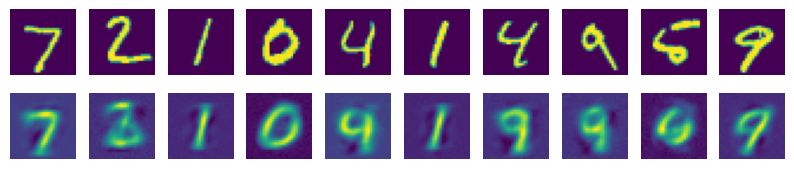

In [21]:
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2)) # Create a figure with 2 rows and 10 columns of subplots
for i in range(examples_to_show):
    # Plot original image in the first row
    a[0][i].imshow(np.reshape(x_image_test[i], (28, 28))) # Reshape 1D vector to 28x28 image for display
    a[0][i].set_axis_off() # Hide axes for cleaner image display

    # Plot reconstructed image in the second row
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    a[1][i].set_axis_off() # Hide axes

plt.show() # Display the plot